# wordslab-images - Install prerequisites

In [18]:
from importlib.metadata import version

## Install Huggingface transformers and diffusers

In [ ]:
pip install accelerate

In [8]:
version('accelerate')

'1.0.0'

In [ ]:
pip install --upgrade transformers sentencepiece protobuf

In [10]:
version('transformers')

'4.45.2'

In [ ]:
pip install --upgrade diffusers

In [3]:
version('diffusers')

'0.30.3'

## Install Pytorch native quantization library torchao

Here is a repository explaining how to use torchao with the diffusers library:

https://github.com/sayakpaul/diffusers-torchao

https://github.com/sayakpaul/diffusers-torchao/blob/main/inference/serialization_and_loading.md

In [ ]:
pip install --upgrade torchao==0.5.0

In [9]:
version('torchao')

'0.5.0'

## Download and test 'FLUX.1 schnell' image generation model

FLUX.1 schnell is a state of the art image generation model released by Black Forest Labs under the very permissive Apache 2.0 licence.

https://blackforestlabs.ai/announcing-black-forest-labs/

It is optimized for speed of generation on consumer hardware.

Note that to run this model you will need :
- **32 GB of CPU RAM**
- **8 GB of GPU VRAM** (16 GB recommanded)
- 17 GB free disk space

Here is the relevant documentation for the Huggingface diffusers implementation:

https://huggingface.co/black-forest-labs/FLUX.1-schnell

https://huggingface.co/docs/diffusers/main/en/api/pipelines/flux

https://gist.github.com/sayakpaul/b664605caf0aa3bf8585ab109dd5ac9c

In [2]:
from diffusers import DiffusionPipeline, FluxTransformer2DModel, AutoencoderKL
from transformers import T5EncoderModel, CLIPTextModel
import torch 

original_repo = "black-forest-labs/FLUX.1-schnell"
quantized_repo = "wordslab-org/FLUX.1-schnell-torchao-int8"

In [7]:
# Allow deserializing torachao quantized tensors 
from torchao.dtypes import AffineQuantizedTensor
from torchao.dtypes.affine_quantized_tensor import PlainAQTLayout, PlainLayoutType, TensorCoreTiledAQTLayout, TensorCoreTiledLayoutType
from torchao.quantization.quant_primitives import ZeroPointDomain

torch.serialization.add_safe_globals([AffineQuantizedTensor,PlainAQTLayout,PlainLayoutType,ZeroPointDomain,TensorCoreTiledAQTLayout,TensorCoreTiledLayoutType])

In [3]:
text_encoder = CLIPTextModel.from_pretrained(
    original_repo, subfolder="text_encoder", torch_dtype=torch.bfloat16
)

In [6]:
text_encoder_2 = T5EncoderModel.from_pretrained(
       quantized_repo, subfolder="text_encoder_2", torch_dtype=torch.bfloat16, use_safetensors=False
)

In [ ]:
transformer = FluxTransformer2DModel.from_pretrained(
     quantized_repo, subfolder="transformer", torch_dtype=torch.bfloat16, use_safetensors=False
)

In [9]:
vae = AutoencoderKL.from_pretrained(
    original_repo, subfolder="vae", torch_dtype=torch.bfloat16
)

In [11]:
# Initialize the pipeline from the 4 models
pipeline = DiffusionPipeline.from_pretrained(
	original_repo, 
    transformer=transformer, 
    vae=vae,
    text_encoder=text_encoder, 
    text_encoder_2=text_encoder_2, 
    torch_dtype=torch.bfloat16
)

# Use this for a 8 GB GPU 
pipeline.enable_sequential_cpu_offload()

# Use this for a 16+ GB GPU
# pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [13]:
def gen_img(prompt):
    return pipeline(prompt, guidance_scale=0.0, num_inference_steps=4, max_sequence_length=256).images[0]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

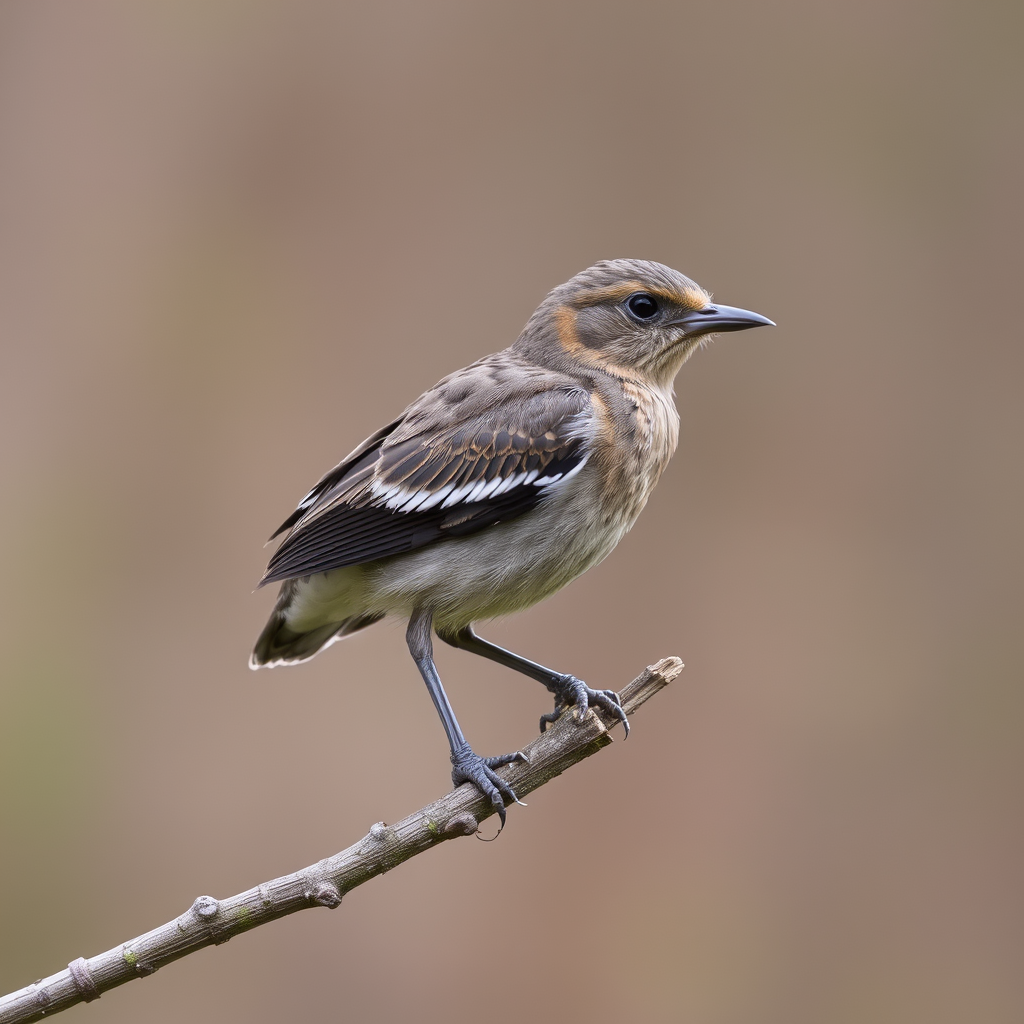

In [22]:
# warmup
gen_img("cat")
gen_img("dog")
gen_img("bird")

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 1min 5s, sys: 2.33 s, total: 1min 8s
Wall time: 1min 16s


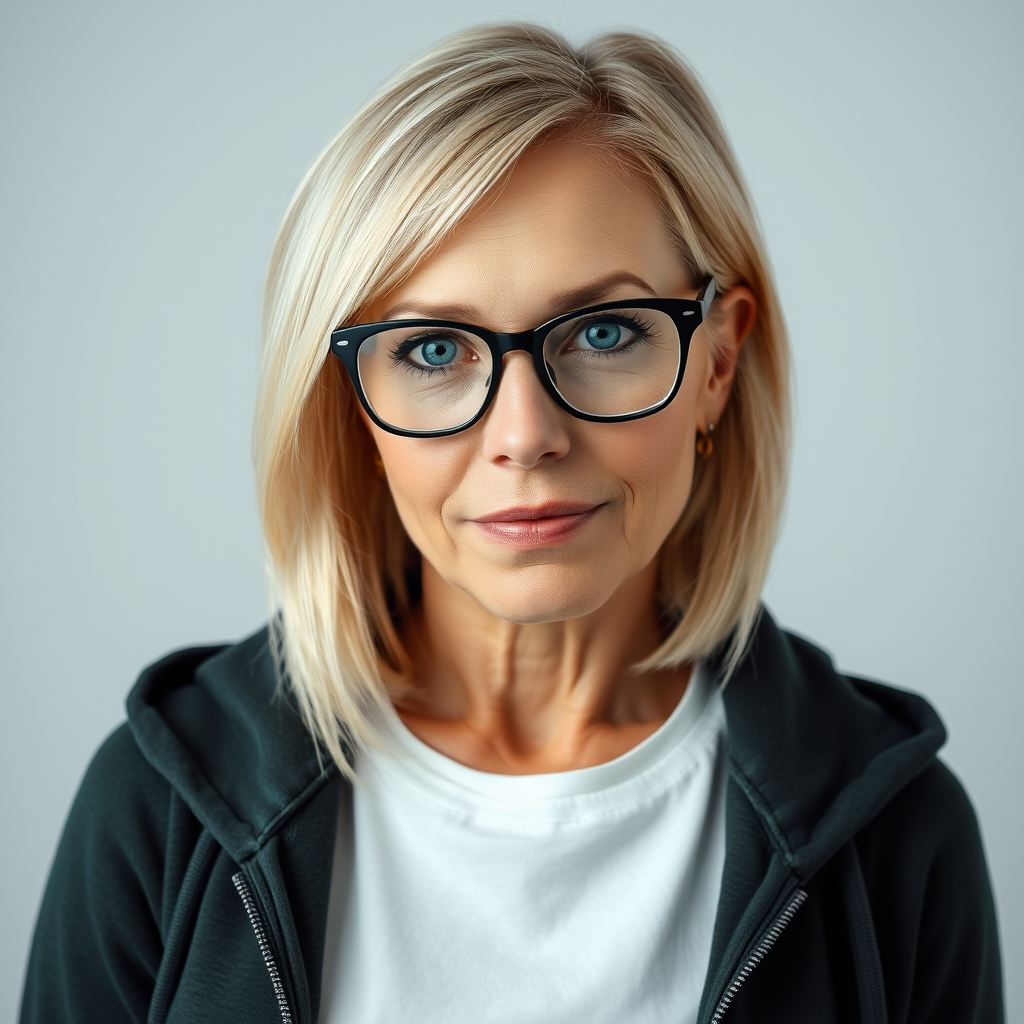

In [21]:
%time  gen_img("studio photo of blonde woman, 45 years old, with short hair, blue eyes and black frame glasses and a dark green hoodie weared on top of a white tshirt")

# For information only - Code used to quantize the model

### Performance tests on RTX A6000 Ada 48GB with Pytorch 2.4 and torchao 0.5.0

#### Full pipeline

Memory after loading the model / Memory during generation at batch size 1 - Generation time

- bf16 : 32 630 / 37 360 MB - 2.5 sec
- int8 : 17 270 / 21 410 MB - 3.1 sec
- int4 :  9 950 / 13 780 MB - 11.5 sec

The pipeline executes the 4 models below, here is the memory necessary to load each model:

#### Text Encoder 1

- bf16 :   700 MB
- int8 : 1 020 MB
- int4 :   810 MB

#### Text Encoder 2

- bf16 : 9 520 MB
- int8 : 5 640 MB
- int4 : 3 620 MB

#### Diffusion Transformer

- bf16 : 23 130 MB
- int8 : 12 200 MB
- int4 :  7 400 MB

#### VAE

- bf16 : 600 MB
- int8 : 670 MB
- int4 : 670 MB

### Quantize the 2 biggest models to 8 bits

In [1]:
from pathlib import Path
from diffusers import DiffusionPipeline, FluxTransformer2DModel, AutoencoderKL
from transformers import T5EncoderModel, CLIPTextModel
from torchao.quantization import quantize_, int8_weight_only, int4_weight_only
import torch 

original_repo = "black-forest-labs/FLUX.1-schnell"

quant_precision = int8_weight_only()
local_model_dir = Path("FLUX.1-schnell-torchao-int8")

# FAILED to reload the transformer in 4 bits on RTX 3070: TensorCoreTiledAQTLayout not supported on CPU,
# because the model is too big to be put on the GPU in bf16 (what the code believes the weights are)
# quant_precision = int4_weight_only(use_hqq=True)
# local_model_dir = Path("FLUX.1-schnell-torchao-int4")

In [ ]:
# Quantize text encoder 2
text_encoder_2 = T5EncoderModel.from_pretrained(
    original_repo, subfolder="text_encoder_2", torch_dtype=torch.bfloat16
)

quantize_(text_encoder_2, quant_precision, device="cuda")
text_encoder_2.save_pretrained(local_model_dir/"text_encoder_2", safe_serialization=False)

In [ ]:
# Quantize diffusion Transformer
transformer = FluxTransformer2DModel.from_pretrained(
    original_repo, subfolder="transformer", torch_dtype=torch.bfloat16
)

quantize_(transformer, quant_precision, device="cuda")
transformer.save_pretrained(model_dir/"transformer", safe_serialization=False)

Now the files are avaiable in the local directory.

Upload them to the target Huggingface repository.